## Worldstart 데이터 시각화
- 루트 디렉토리에 파일 저장
  -  ../dataset/hr_dataset/~
     -  Ref: https://earth.esa.int/eogateway/documents/20142/37627/SPOT-6-7-imagery-user-guide.pdf
  -  ../dataset/lr_dataset/L2A/~
     -  Ref: https://docs.sentinel-hub.com/api/latest/data/sentinel-2-l2a/
- 첫 번째 쉘에 image_name에 이미지 이름 지정

In [ ]:
import os
import glob
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
import numpy as np
import natsort
import rasterio

image_name = 'Landcover-1784876'

dataset_root = '../dataset'
hr_img_dir = os.path.join(dataset_root, 'hr_dataset', image_name)
lr_img_dir = os.path.join(dataset_root, 'lr_dataset', image_name, 'L2A')

hr_files = {}
for ext in ['_pan.tiff', '_ps.tiff', '_rgb.png', '_rgbn.tiff']:
    hr_files[ext] = os.path.join(hr_img_dir, f'{image_name}{ext}')

lr_files = {}
for ext in ['-CLM.tiff', '-CLP.tiff', '-dataMask.tiff', '-L2A_data.tiff', '-SCL.tiff', '.metadata']:
    lr_files[ext] = natsort.natsorted(glob.glob(os.path.join(lr_img_dir, f'*{ext}')))

print(f'HR num: {len(hr_files)}')
print(f'LR num: {len(lr_files["-L2A_data.tiff"])}')

print(f'HR_keys: {hr_files.keys()}')
print(f'LR_keys: {lr_files.keys()}')

HR num: 4
LR num: 8
HR_keys: dict_keys(['_pan.tiff', '_ps.tiff', '_rgb.png', '_rgbn.tiff'])
LR_keys: dict_keys(['-CLM.tiff', '-CLP.tiff', '-dataMask.tiff', '-L2A_data.tiff', '-SCL.tiff', '.metadata'])


## HR 이미지 시각화
- HR (High-Resolution) 이미지: SPOT6/7 위성

  - 12비트 해상도로 측정한 고해상도 이미지

- 데이터 값: 반사율을 스케일링한 디지털값(Digital Number)

  - 위성이 기록한 원시 디지털 값(DN)에서 대기 보정을 적용한 반사율을 구한 뒤, 정수로 저장하기 위해 스케일인자 10,000을 곱한값
  - 값의 범위는 [0, 10000] 사이의 정수(UNIT16)
  - 위성 영상의 센서 측정값은 도시를 제외하면 대부분 낮은 범위에 분포하기 때문에 대부분 어두움
  - 이미지 내 최솟값,최댓값을 이용해 min-max 스케일링 => 값의 범위를 [0,1]로 만듬과 동시에 명암 대비 차이를 늘려 시각화

### 이미지 타입
- 저해상도 rgbn 이미지 -> rgb만 시각화
  - (1.5m/pixel, 263 x 263)
- 고해상도 pan 이미지
  - (1.5m/pixel, 1054 x 1054)
- 고해상도 ps 이미지 (rgbn과 pan 이미지를 이용하여 펜샤프닝)
  - (1.5m/pixel, 1054 x 1054)

/opt/homebrew/anaconda3/envs/temp/lib/python3.10/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


File: ../dataset/hr_dataset/Landcover-1784876/Landcover-1784876_ps.tiff
- Width x Height: 1054 x 1054
- Band Count: 4
- Dtype: uint16
Max: 2681, Min: 0
File: ../dataset/hr_dataset/Landcover-1784876/Landcover-1784876_pan.tiff
- Width x Height: 1054 x 1054
- Band Count: 1
- Dtype: uint16
Max: 4112, Min: 0
File: ../dataset/hr_dataset/Landcover-1784876/Landcover-1784876_rgbn.tiff
- Width x Height: 263 x 263
- Band Count: 4
- Dtype: uint16
Max: 1626, Min: 0


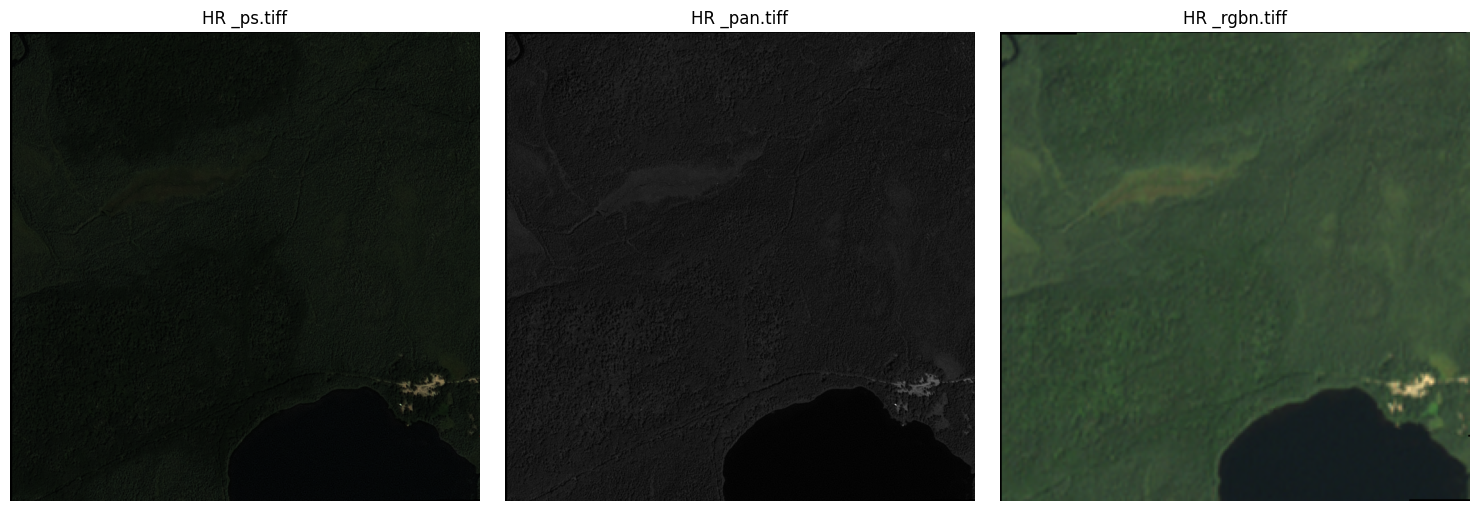

In [12]:
# 이미지 정규화
def normalize_for_display(image):
    image = (image - np.min(image)) / (np.max(image) - np.min(image))
    return np.clip(image, 0, 1)

hr_exts = ['_ps.tiff', '_pan.tiff', '_rgbn.tiff']

fig, axes = plt.subplots(1, len(hr_exts), figsize=(15, 5))

for i, ext in enumerate(hr_exts):
    file_path = hr_files.get(ext)
    if file_path and os.path.exists(file_path):
        with rasterio.open(file_path) as src:
            print(f"File: {file_path}")
            print(f"- Width x Height: {src.width} x {src.height}")
            print(f"- Band Count: {src.count}")
            print(f"- Dtype: {src.dtypes[0]}")

            if src.count >= 3: # 밴드 갯수가 3 이상(rgbn)
                img = src.read([1, 2, 3])  # RGB만 선택

            elif src.count == 1:
                img = src.read()

            print(f"Max: {np.max(img)}, Min: {np.min(img)}")
            img = img.transpose(1, 2, 0) # rasterio는 채널 퍼스트(C,H,W)로 읽기 때문에 (H,W,C)로 변환

            img_norm = normalize_for_display(img.astype(np.float32))

            if ext == '_ps.tiff':  # 정규화된 HR_ps 이미지 저장
                hr_ps_image = img_norm.copy()

            axes[i].imshow(img_norm, cmap='gray' if src.count == 1 else None)
            axes[i].set_title(f'HR {ext}')
            axes[i].axis('off')
    else:
        axes[i].set_title(f'No file for {ext}')
        axes[i].axis('off')

plt.tight_layout()
plt.show()


## NIR 밴드 시각화
1. NIR 단일 채널 시각화(gray scale)

2. 가상 컬러 합성(False-color Composite)
   - NIR을 R에, Red를 G에, Green을 B에 매핑
   - 농업, 산림 모니터링 등에서 매우 흔히 쓰이는 방식
   - 식생이 붉게 강조됨 → 경작지 구분에 좋음

3. NDVI 시각화
   - 식생 분포를 직관적으로 시각화 가능 (녹색 = 식생, 빨강 = 비식생)

File: ../dataset/hr_dataset/Landcover-1784876/Landcover-1784876_ps.tiff
- Width x Height: 1054 x 1054
- Band Count: 4
- Dtype: uint16
description: (None, None, None, None)


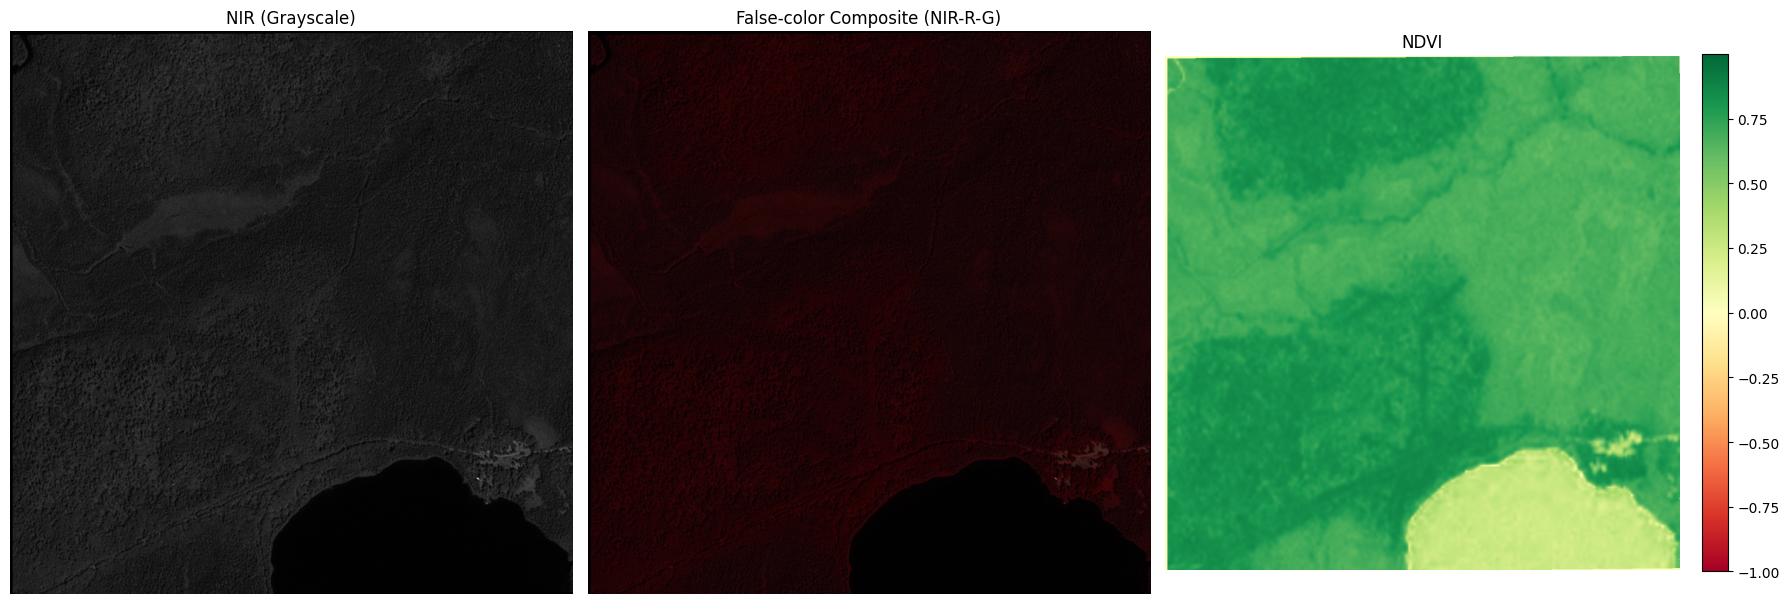

In [3]:
file_path = hr_files.get('_ps.tiff')

if file_path and os.path.exists(file_path):
    with rasterio.open(file_path) as src:
        print(f"File: {file_path}")
        print(f"- Width x Height: {src.width} x {src.height}")
        print(f"- Band Count: {src.count}")
        print(f"- Dtype: {src.dtypes[0]}")
        print(f'description: {src.descriptions}')

        # 4개 밴드 읽기: R(1), G(2), B(3), NIR(4)
        img_all = src.read([1, 2, 3, 4])  # (4, H, W)

        # NIR 채널 (4번째)
        img_nir = normalize_for_display(img_all[3].astype(np.float32))

        # RGB (1~3 밴드)
        img_rgb = img_all[:3].transpose(1, 2, 0)
        img_rgb_norm = normalize_for_display(img_rgb.astype(np.float32))

        # False-color Composite (NIR-R-G)
        false_color = np.stack([
            img_all[3],  # NIR -> R channel
            img_all[0],  # R   -> G channel
            img_all[1],  # G   -> B channel
        ], axis=0).transpose(1, 2, 0)
        false_color_norm = normalize_for_display(false_color.astype(np.float32))

        # NDVI 계산: (NIR - Red) / (NIR + Red), 나누기 0 방지 위해 epsilon 추가
        nir = img_all[3].astype(np.float32)
        red = img_all[0].astype(np.float32)
        epsilon = 1e-6
        ndvi = (nir - red) / (nir + red + epsilon)

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # 1. NIR (Grayscale)
    axes[0].imshow(img_nir, cmap='gray')
    axes[0].set_title('NIR (Grayscale)')
    axes[0].axis('off')

    # 2. False-color Composite (NIR-R-G)
    axes[1].imshow(false_color_norm)
    axes[1].set_title('False-color Composite (NIR-R-G)')
    axes[1].axis('off')

    # 3. NDVI (컬러맵 적용)
    im = axes[2].imshow(ndvi, cmap='RdYlGn')
    axes[2].set_title('NDVI')
    axes[2].axis('off')
    fig.colorbar(im, ax=axes[2], fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()

else:
    print("No _ps.tiff file found.")


## LR 이미지 시각화
- LR (Low-Resolution) 이미지: Sentinel-2 L2A
  - 대기 산란, 흡수 등 대기 효과를 보정하여 실제 지표면 반사율을 근사한 Level-2A 이미지

- 데이터 값: 표면 반사율 (Surface Reflectance)
  - 대부분은 0 ~ 0.4에 분포
  - 정수로 값을 저장하기 위해 스케일링 인자를 곱해 Digital Number(DN)으로 저장하는 경우도 있으나 현재 데이터에서는 반사율을 그대로 저장 (e.g., 10000 * 0.4 = 4000으로 저장. 분석 시에는 사디 DN으로 나누어 실수로 변환)
  - 예외적으로 1.0을 넘는 경우도 있음
  - min-max 스케일링을 통해 명암 대비 차이를 늘려 시각화

File: ../dataset/lr_dataset/Landcover-1784876/L2A/Landcover-1784876-1-L2A_data.tiff
- Width x Height: 160 x 156
- Band Count: 12
- Dtype: float32
min: 0.0005000000237487257, max: 0.14820000529289246
File: ../dataset/lr_dataset/Landcover-1784876/L2A/Landcover-1784876-2-L2A_data.tiff
- Width x Height: 160 x 156
- Band Count: 12
- Dtype: float32
min: 0.01209999993443489, max: 0.3901999890804291
File: ../dataset/lr_dataset/Landcover-1784876/L2A/Landcover-1784876-3-L2A_data.tiff
- Width x Height: 160 x 156
- Band Count: 12
- Dtype: float32
min: 0.014100000262260437, max: 0.8560000061988831
File: ../dataset/lr_dataset/Landcover-1784876/L2A/Landcover-1784876-4-L2A_data.tiff
- Width x Height: 160 x 156
- Band Count: 12
- Dtype: float32
min: 0.00570000009611249, max: 0.753600001335144
File: ../dataset/lr_dataset/Landcover-1784876/L2A/Landcover-1784876-5-L2A_data.tiff
- Width x Height: 160 x 156
- Band Count: 12
- Dtype: float32
min: 0.0005000000237487257, max: 0.24079999327659607
File: ../datas

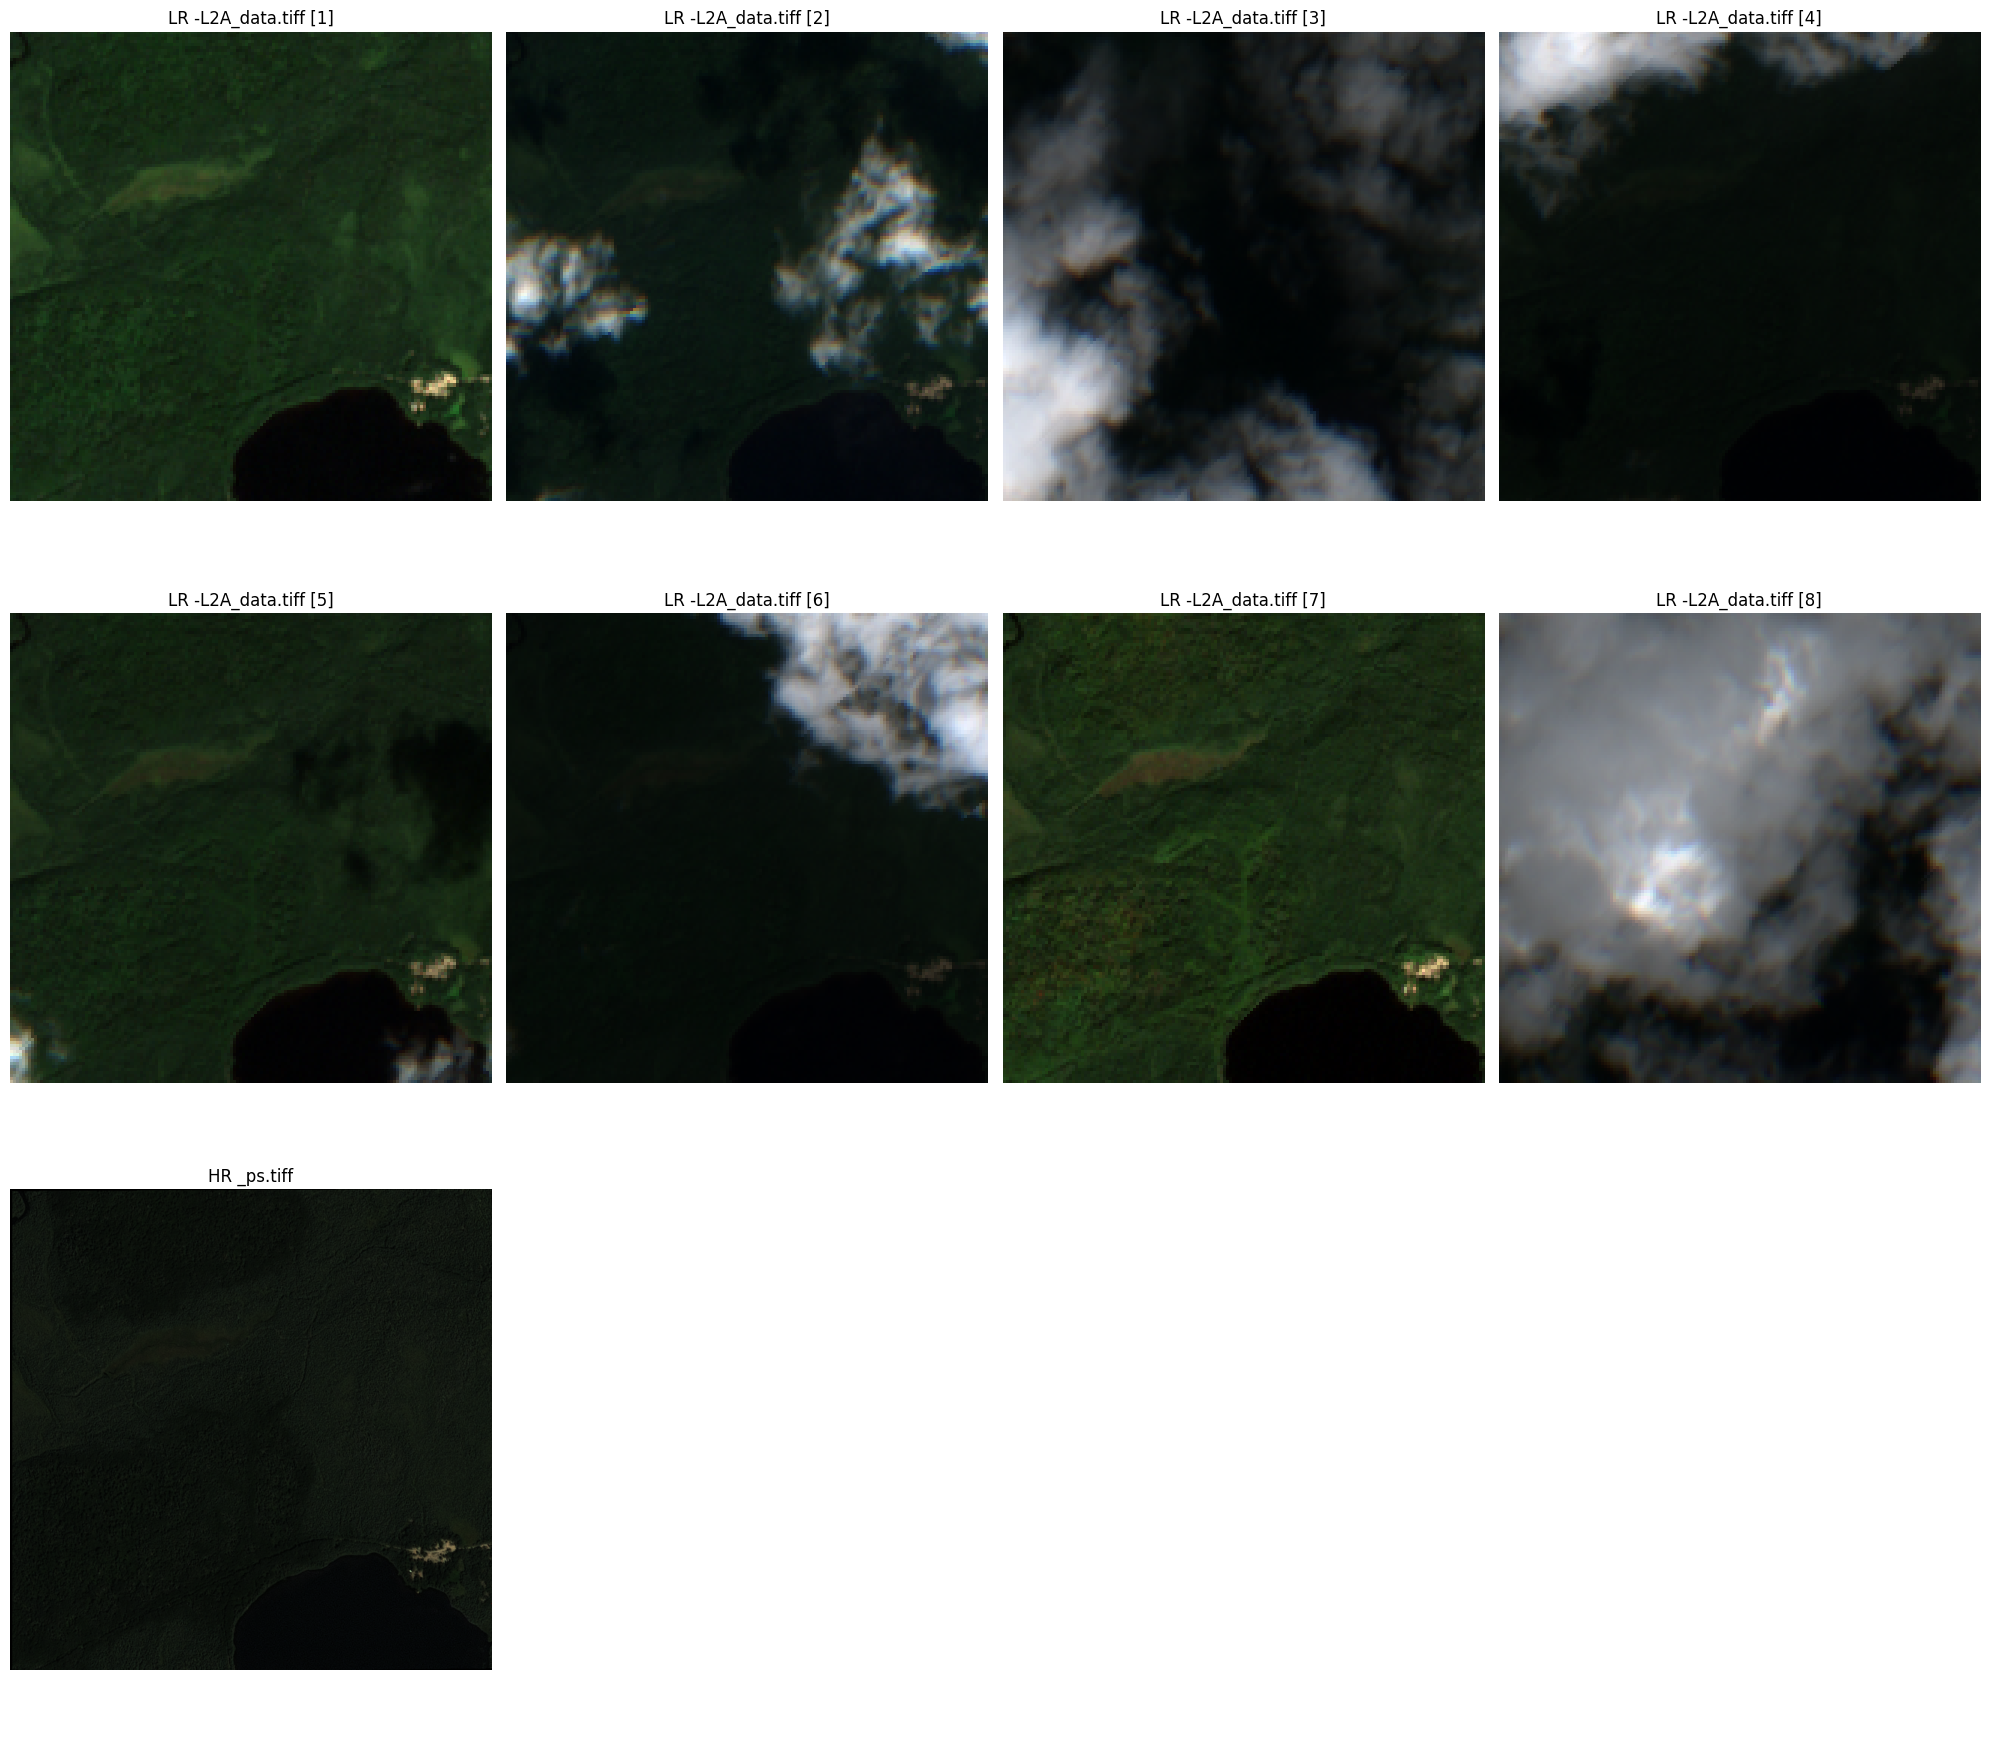

In [4]:
lr_ext = '-L2A_data.tiff'
file_list = lr_files.get(lr_ext)

if file_list and len(file_list) > 0:
    n = len(file_list)
    rows = 2
    cols = 4
    total_plots = rows * cols + 1  # 마지막 1개는 HR 이미지
    fig, axes = plt.subplots(rows + 1, cols, figsize=(5 * cols, 6 * (rows + 1)))
    axes = axes.flatten()  # 2차원 배열 -> 1차원으로 flatten

    for i, file_path in enumerate(file_list):
        if os.path.exists(file_path):
            with rasterio.open(file_path) as src:
                print(f"File: {file_path}")
                print(f"- Width x Height: {src.width} x {src.height}")
                print(f"- Band Count: {src.count}")
                print(f"- Dtype: {src.dtypes[0]}")

                img = src.read([4, 3, 2])  # shape: (3, H, W)
                img = img.transpose(1, 2, 0)  # (H, W, 3)
                print(f"min: {img.min()}, max: {img.max()}")  # 값 범위 확인

                max_val = np.max(img)
                img_norm = normalize_for_display(img) # 정규화
            
            axes[i].imshow(img_norm)
            axes[i].set_title(f'LR {lr_ext} [{i+1}]')
            axes[i].axis('off')
        else:
            axes[i].set_title(f'File not found [{i+1}]')
            axes[i].axis('off')

    # 남은 subplot 빈 칸 처리 (파일 개수가 8보다 적을 때)
    for j in range(i+1, rows*cols):
        axes[j].axis('off')
        
    axes[rows * cols].imshow(hr_ps_image)
    axes[rows * cols].set_title('HR _ps.tiff')
    axes[rows * cols].axis('off')
    for k in range(rows * cols + 1, len(axes)):
        axes[k].axis('off')

    plt.tight_layout()
    plt.show()
else:
    print(f"No files found for {lr_ext}")


## 구름 마스크 시각화
- -CLM.tiff: 구름에 대한 이진 마스크
  - 0 - no clouds -> black
  - 1 - clouds -> white
  - 255 - no data -> red
- -CLP.tiff: 구름이 있을 확률 마스크
  - 0 ~ 255(divide by 255 to get to the [0-1] range)

File: ../dataset/lr_dataset/Landcover-1784876/L2A/Landcover-1784876-1-CLM.tiff
- Width x Height: 160 x 156
- Band Count: 1
- Dtype: float32
min: 0.0, max: 0.0
File: ../dataset/lr_dataset/Landcover-1784876/L2A/Landcover-1784876-2-CLM.tiff
- Width x Height: 160 x 156
- Band Count: 1
- Dtype: float32
min: 0.0, max: 1.0
File: ../dataset/lr_dataset/Landcover-1784876/L2A/Landcover-1784876-3-CLM.tiff
- Width x Height: 160 x 156
- Band Count: 1
- Dtype: float32
min: 0.0, max: 1.0
File: ../dataset/lr_dataset/Landcover-1784876/L2A/Landcover-1784876-4-CLM.tiff
- Width x Height: 160 x 156
- Band Count: 1
- Dtype: float32
min: 0.0, max: 1.0
File: ../dataset/lr_dataset/Landcover-1784876/L2A/Landcover-1784876-5-CLM.tiff
- Width x Height: 160 x 156
- Band Count: 1
- Dtype: float32
min: 0.0, max: 0.0
File: ../dataset/lr_dataset/Landcover-1784876/L2A/Landcover-1784876-6-CLM.tiff
- Width x Height: 160 x 156
- Band Count: 1
- Dtype: float32
min: 0.0, max: 1.0
File: ../dataset/lr_dataset/Landcover-1784876/

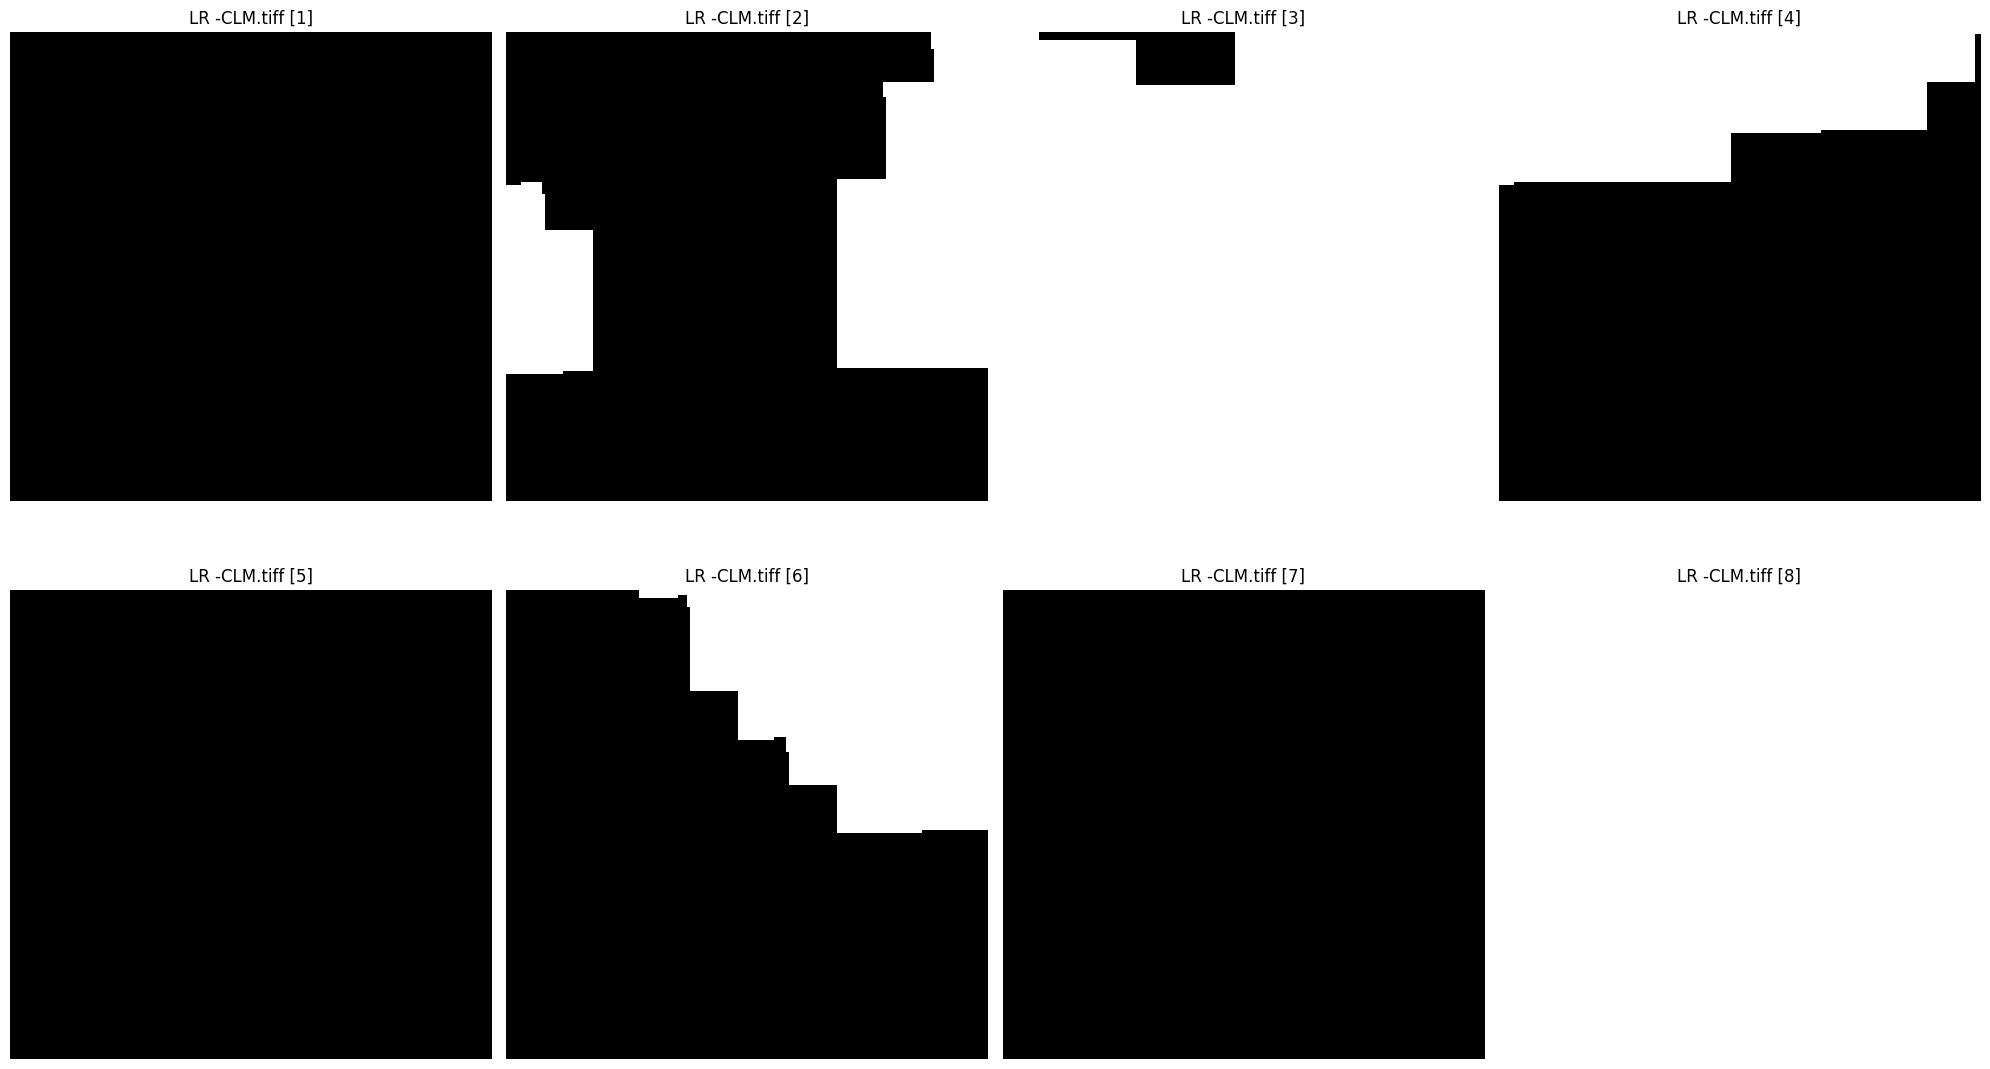

In [ ]:
lr_ext = '-CLM.tiff'
file_list = lr_files.get(lr_ext)

if file_list and len(file_list) > 0:
    n = len(file_list)
    rows = 2
    cols = 4
    fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 6 * rows))
    axes = axes.flatten()

    for i, file_path in enumerate(file_list):
        if os.path.exists(file_path):
            with rasterio.open(file_path) as src:
                print(f"File: {file_path}")
                print(f"- Width x Height: {src.width} x {src.height}")
                print(f"- Band Count: {src.count}")
                print(f"- Dtype: {src.dtypes[0]}")

                # 단일 밴드이므로 1번 밴드 읽기
                img = src.read(1)

            cmap = ListedColormap(['black', 'white', 'red'])  # 0=black, 1=white, 255=red
            bounds = [-0.5, 0.5, 1.5, 255.5]
            norm = BoundaryNorm(bounds, cmap.N)

            img_display = np.copy(img)
            img_display[img == 255] = 2  # NoData는 2로 매핑

            axes[i].imshow(img_display, cmap=cmap, norm=norm)
            axes[i].set_title(f'LR {lr_ext} [{i+1}]')
            axes[i].axis('off')
        else:
            axes[i].set_title(f'File not found [{i+1}]')
            axes[i].axis('off')

    for j in range(i+1, rows*cols):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()
else:
    print(f"No files found for {lr_ext}")

File: ../dataset/lr_dataset/Landcover-1784876/L2A/Landcover-1784876-1-CLP.tiff
- Width x Height: 160 x 156
- Band Count: 1
- Dtype: float32
min: 0.0, max: 3.0
File: ../dataset/lr_dataset/Landcover-1784876/L2A/Landcover-1784876-2-CLP.tiff
- Width x Height: 160 x 156
- Band Count: 1
- Dtype: float32
min: 0.0, max: 238.0
File: ../dataset/lr_dataset/Landcover-1784876/L2A/Landcover-1784876-3-CLP.tiff
- Width x Height: 160 x 156
- Band Count: 1
- Dtype: float32
min: 3.0, max: 255.0
File: ../dataset/lr_dataset/Landcover-1784876/L2A/Landcover-1784876-4-CLP.tiff
- Width x Height: 160 x 156
- Band Count: 1
- Dtype: float32
min: 0.0, max: 254.0
File: ../dataset/lr_dataset/Landcover-1784876/L2A/Landcover-1784876-5-CLP.tiff
- Width x Height: 160 x 156
- Band Count: 1
- Dtype: float32
min: 0.0, max: 143.0
File: ../dataset/lr_dataset/Landcover-1784876/L2A/Landcover-1784876-6-CLP.tiff
- Width x Height: 160 x 156
- Band Count: 1
- Dtype: float32
min: 0.0, max: 255.0
File: ../dataset/lr_dataset/Landcove

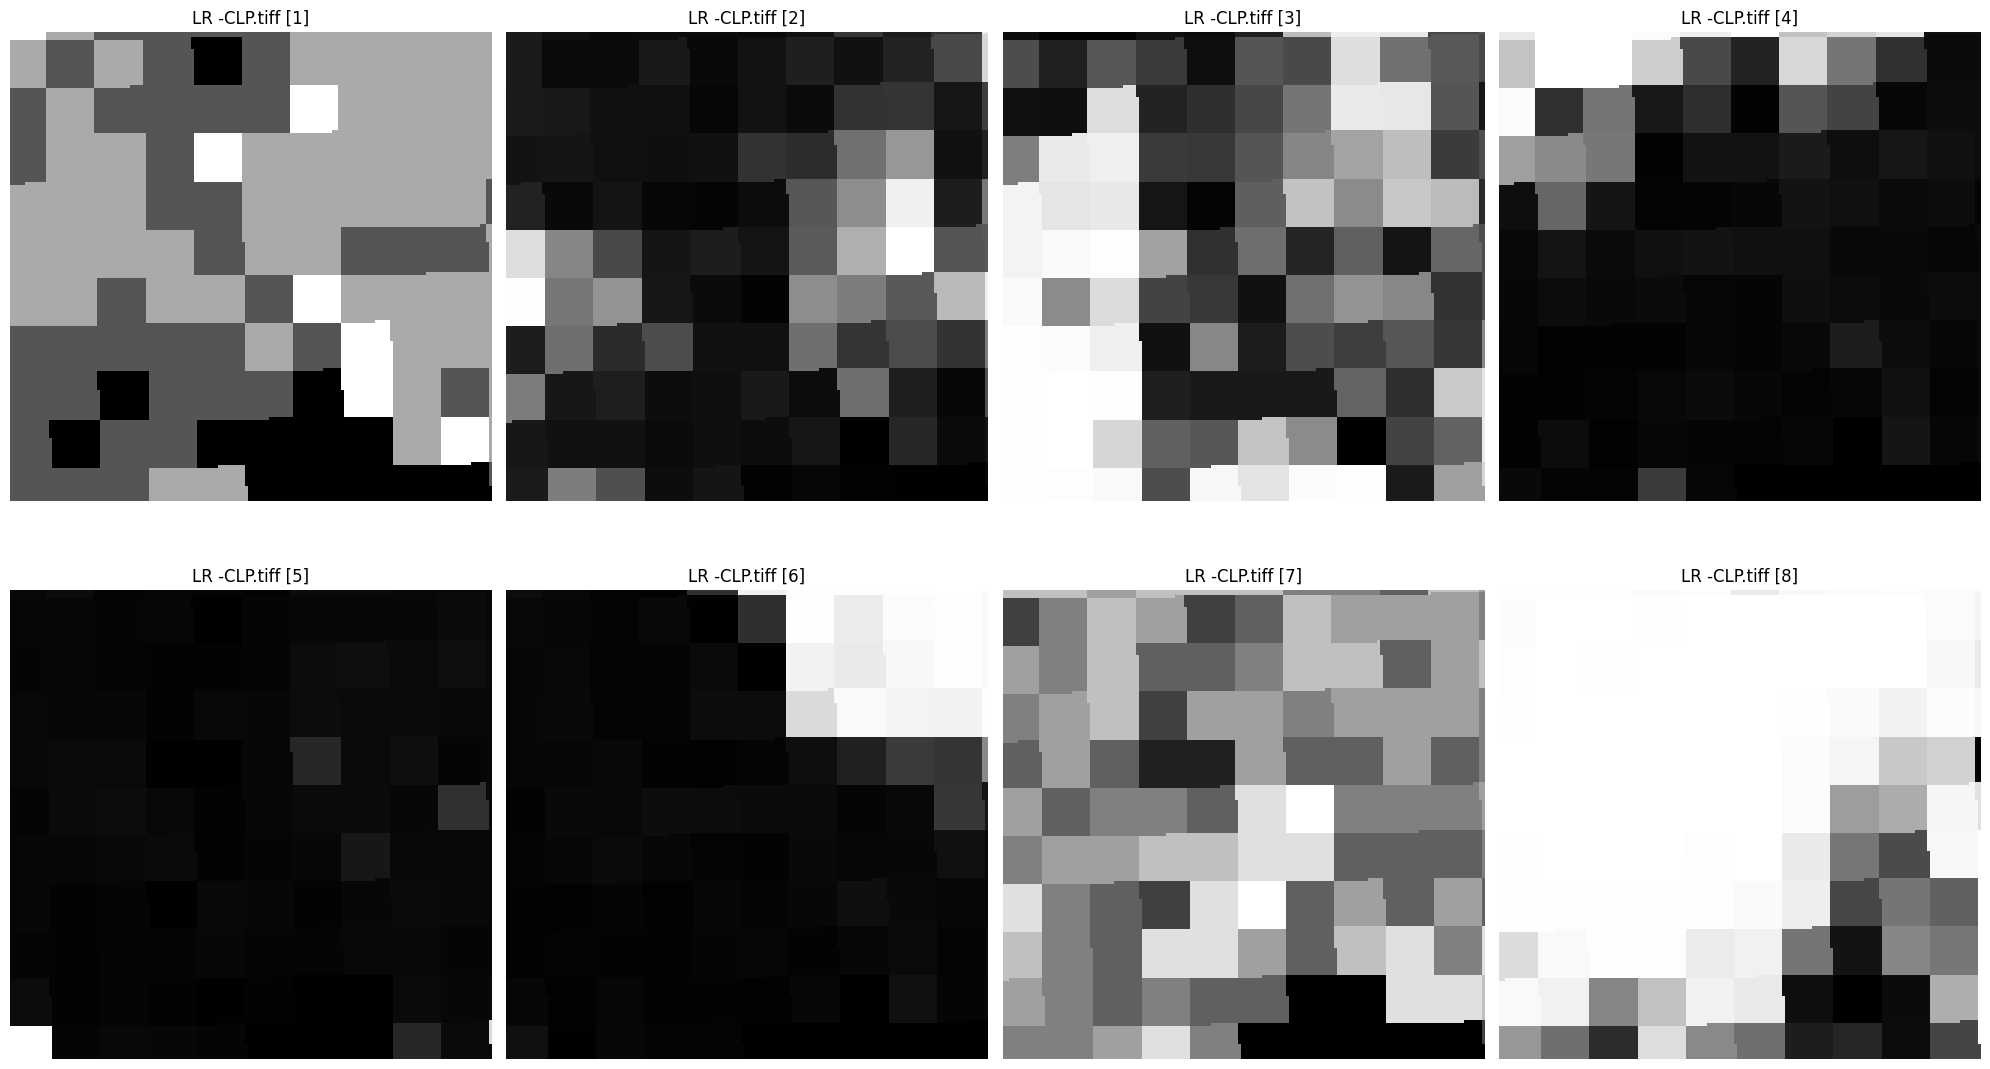

In [ ]:
lr_ext = '-CLP.tiff'
file_list = lr_files.get(lr_ext)

if file_list and len(file_list) > 0:
    n = len(file_list)
    rows = 2
    cols = 4
    fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 6 * rows))
    axes = axes.flatten()

    for i, file_path in enumerate(file_list):
        if os.path.exists(file_path):
            with rasterio.open(file_path) as src:
                print(f"File: {file_path}")
                print(f"- Width x Height: {src.width} x {src.height}")
                print(f"- Band Count: {src.count}")
                print(f"- Dtype: {src.dtypes[0]}")

                img = src.read(1)

            axes[i].imshow(img, cmap='gray')
            axes[i].set_title(f'LR {lr_ext} [{i+1}]')
            axes[i].axis('off')
        else:
            axes[i].set_title(f'File not found [{i+1}]')
            axes[i].axis('off')

    for j in range(i+1, rows*cols):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()
else:
    print(f"No files found for {lr_ext}")


## 데이터 마스크 시각화
- 데이터에서 픽셀 측정값의 유효성을 나타내는 마스크 시각화
- 0 - no data -> black
- 1 - data -> white

File: ../dataset/lr_dataset/Landcover-1784876/L2A/Landcover-1784876-1-dataMask.tiff
- Width x Height: 160 x 156
- Band Count: 1
- Dtype: float32
File: ../dataset/lr_dataset/Landcover-1784876/L2A/Landcover-1784876-2-dataMask.tiff
- Width x Height: 160 x 156
- Band Count: 1
- Dtype: float32
File: ../dataset/lr_dataset/Landcover-1784876/L2A/Landcover-1784876-3-dataMask.tiff
- Width x Height: 160 x 156
- Band Count: 1
- Dtype: float32
File: ../dataset/lr_dataset/Landcover-1784876/L2A/Landcover-1784876-4-dataMask.tiff
- Width x Height: 160 x 156
- Band Count: 1
- Dtype: float32
File: ../dataset/lr_dataset/Landcover-1784876/L2A/Landcover-1784876-5-dataMask.tiff
- Width x Height: 160 x 156
- Band Count: 1
- Dtype: float32
File: ../dataset/lr_dataset/Landcover-1784876/L2A/Landcover-1784876-6-dataMask.tiff
- Width x Height: 160 x 156
- Band Count: 1
- Dtype: float32
File: ../dataset/lr_dataset/Landcover-1784876/L2A/Landcover-1784876-7-dataMask.tiff
- Width x Height: 160 x 156
- Band Count: 1
- 

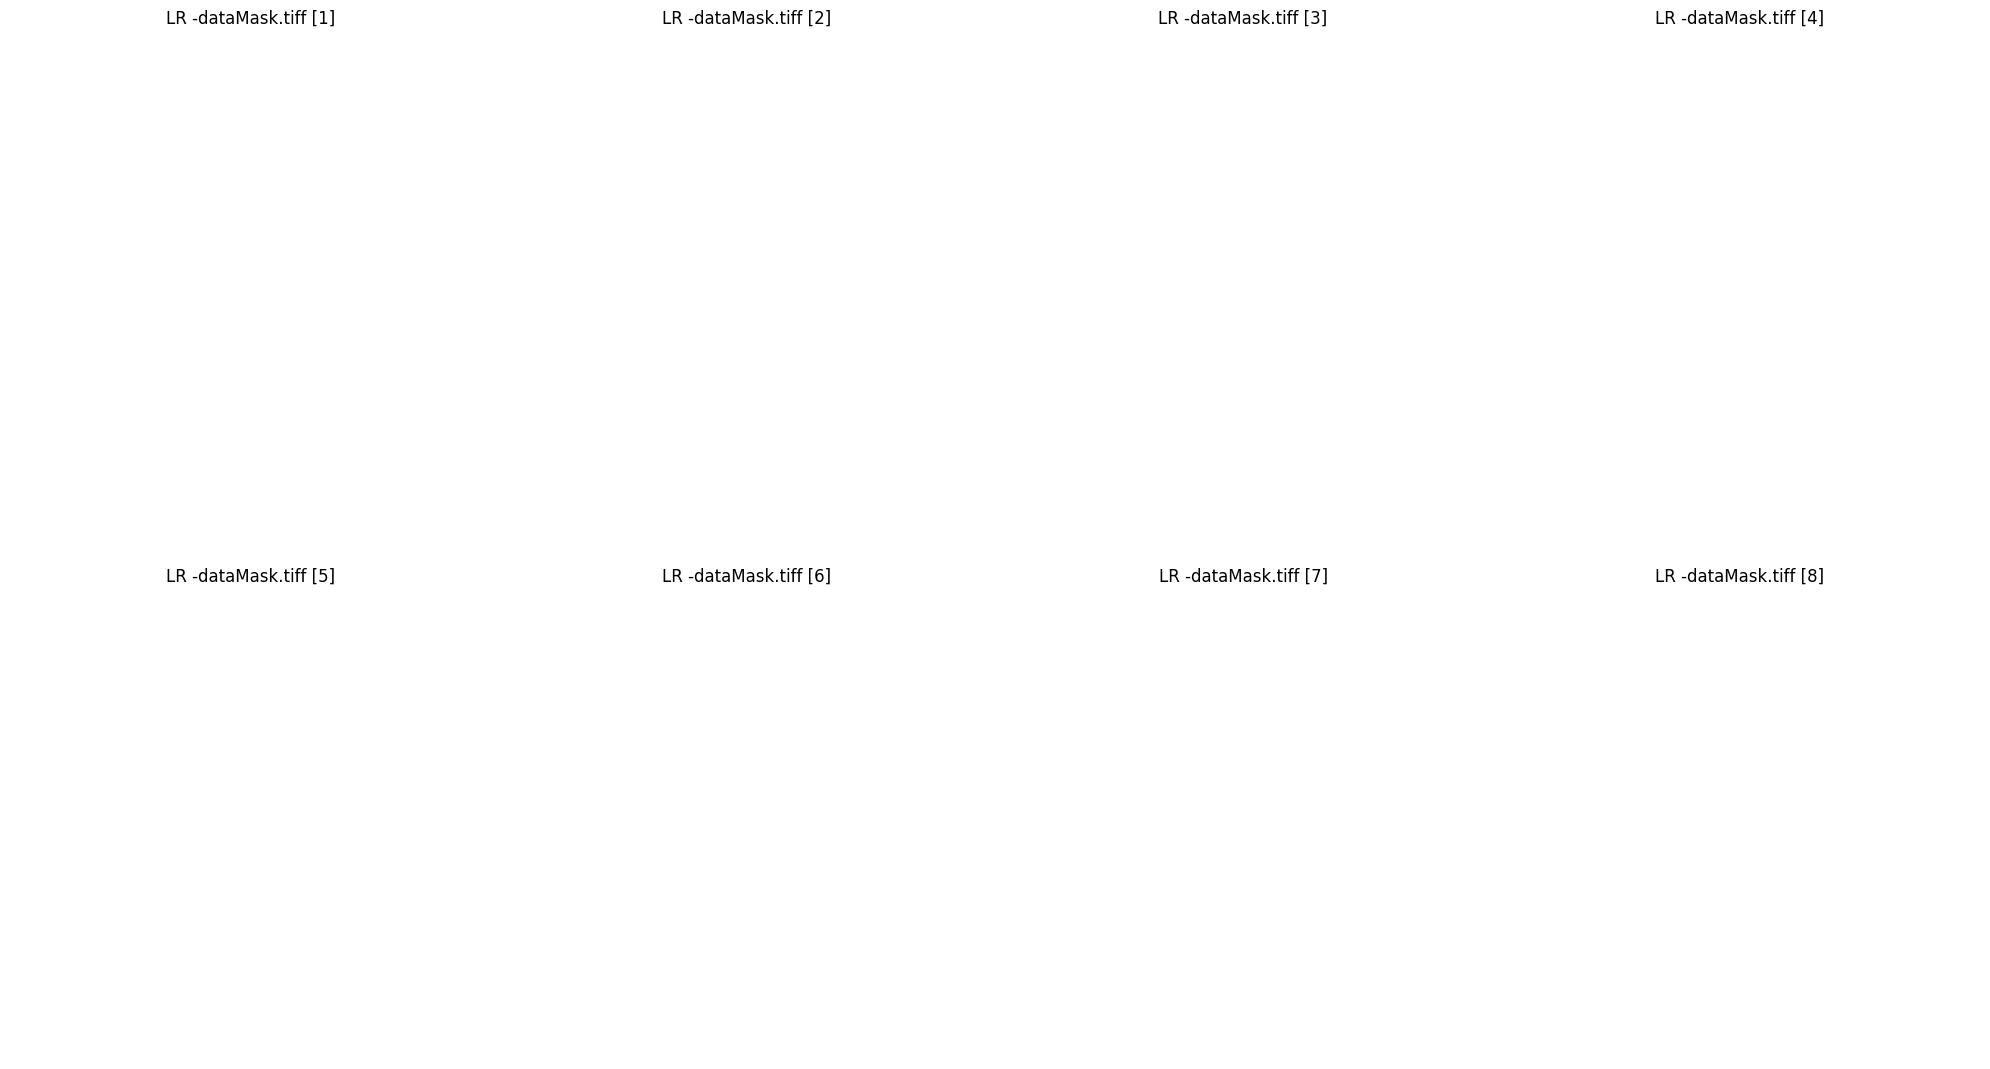

In [7]:
lr_ext = '-dataMask.tiff'
file_list = lr_files.get(lr_ext)

if file_list and len(file_list) > 0:
    n = len(file_list)
    rows = 2
    cols = 4
    fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 6 * rows))
    axes = axes.flatten()

    for i, file_path in enumerate(file_list):
        if os.path.exists(file_path):
            with rasterio.open(file_path) as src:
                
                print(f"File: {file_path}")
                print(f"- Width x Height: {src.width} x {src.height}")
                print(f"- Band Count: {src.count}")
                print(f"- Dtype: {src.dtypes[0]}")

                img = src.read(1)
    
            axes[i].imshow(img, cmap='gray', vmin=0, vmax=1)
            axes[i].set_title(f'LR {lr_ext} [{i+1}]')
            axes[i].axis('off')
        else:
            axes[i].set_title(f'File not found [{i+1}]')
            axes[i].axis('off')

    for j in range(i+1, rows*cols):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()
else:
    print(f"No files found for {lr_ext}")


## 장면 분류 맵(SCL) 시각화
    0: No Data -> black
    1: Saturated / Defective -> red
    2: Dark Area Pixels -> gray
    3: Cloud Shadows -> brown
    4: Vegetation -> green
    5: Bare Soils -> yellow
    6: Water -> blue
    7: Clouds low probability / Unclassified -> medium gray
    8: Clouds medium probability -> light gray
    9: Clouds high probability -> very light gray
    10: Cirrus -> light blue/purple
    11: Snow / Ice -> cyan

File: ../dataset/lr_dataset/Landcover-1784876/L2A/Landcover-1784876-1-SCL.tiff
- Width x Height: 160 x 156
- Band Count: 1
- Dtype: float32
File: ../dataset/lr_dataset/Landcover-1784876/L2A/Landcover-1784876-2-SCL.tiff
- Width x Height: 160 x 156
- Band Count: 1
- Dtype: float32
File: ../dataset/lr_dataset/Landcover-1784876/L2A/Landcover-1784876-3-SCL.tiff
- Width x Height: 160 x 156
- Band Count: 1
- Dtype: float32
File: ../dataset/lr_dataset/Landcover-1784876/L2A/Landcover-1784876-4-SCL.tiff
- Width x Height: 160 x 156
- Band Count: 1
- Dtype: float32
File: ../dataset/lr_dataset/Landcover-1784876/L2A/Landcover-1784876-5-SCL.tiff
- Width x Height: 160 x 156
- Band Count: 1
- Dtype: float32
File: ../dataset/lr_dataset/Landcover-1784876/L2A/Landcover-1784876-6-SCL.tiff
- Width x Height: 160 x 156
- Band Count: 1
- Dtype: float32
File: ../dataset/lr_dataset/Landcover-1784876/L2A/Landcover-1784876-7-SCL.tiff
- Width x Height: 160 x 156
- Band Count: 1
- Dtype: float32
File: ../dataset/lr_

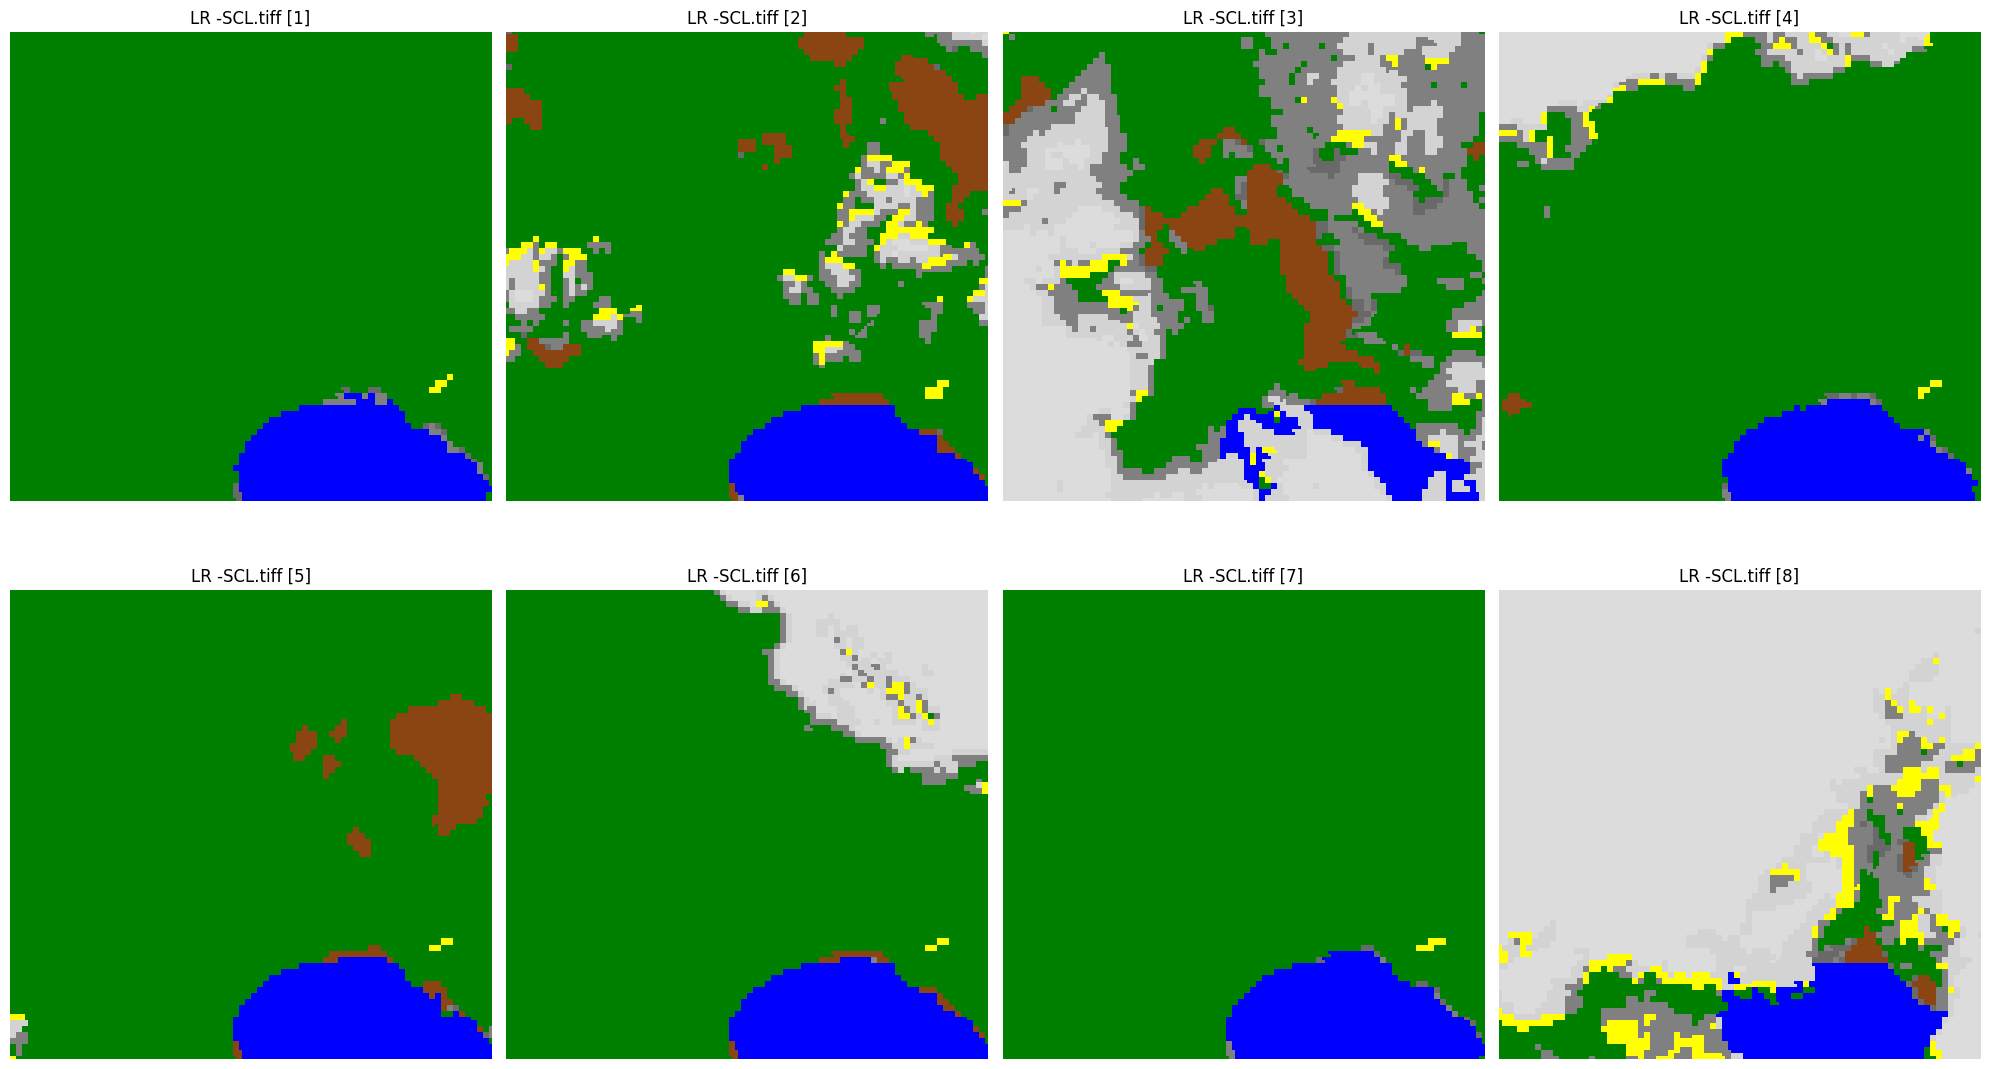

In [ ]:
lr_ext = '-SCL.tiff'
file_list = lr_files.get(lr_ext)

# 클래스별 색상 지정
colors = [
    'black',            # 0: No Data
    'red',              # 1: Saturated / Defective
    'dimgray',          # 2: Dark Area Pixels
    'saddlebrown',      # 3: Cloud Shadows
    'green',            # 4: Vegetation
    'yellow',           # 5: Bare Soils
    'blue',             # 6: Water
    'gray',             # 7: Clouds low probability / Unclassified
    'lightgray',        # 8: Clouds medium probability
    'gainsboro',        # 9: Clouds high probability
    'mediumpurple',     # 10: Cirrus
    'cyan'              # 11: Snow / Ice
]

cmap = ListedColormap(colors)
bounds = np.arange(-0.5, 12, 1)  # 클래스 경계값 (0~11)
norm = BoundaryNorm(bounds, cmap.N)

if file_list and len(file_list) > 0:
    n = len(file_list)
    rows = 2
    cols = 4
    fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 6 * rows))
    axes = axes.flatten()

    for i, file_path in enumerate(file_list):
        if os.path.exists(file_path):
            with rasterio.open(file_path) as src:
                print(f"File: {file_path}")
                print(f"- Width x Height: {src.width} x {src.height}")
                print(f"- Band Count: {src.count}")
                print(f"- Dtype: {src.dtypes[0]}")

                img = src.read(1)  # SCL은 클래스 인덱스, 정규화 하면 안됨
                img = img.astype(np.int32)  # float32 정수 변환


            axes[i].imshow(img, cmap=cmap, norm=norm)
            axes[i].set_title(f'LR {lr_ext} [{i+1}]')
            axes[i].axis('off')
        else:
            axes[i].set_title(f'File not found [{i+1}]')
            axes[i].axis('off')

    for j in range(i+1, rows*cols):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()
else:
    print(f"No files found for {lr_ext}")
